In [5]:
import re
from pathlib import Path
from typing import Union, Dict
import pandas as pd

def _detect_flag_from_text(text: str, names: tuple) -> Union[bool, None]:
    if not text:
        return None
    txt = text.lower()
    for n in names:
        m = re.search(rf"\b{re.escape(n)}\s*[:=]\s*(true|false)\b", txt, re.I)
        if m:
            return True if m.group(1).lower() == "true" else False
    for n in names:
        m2 = re.search(rf"\b{re.escape(n)}\s*(true|false)\b", txt, re.I)
        if m2:
            return True if m2.group(1).lower() == "true" else False
        if re.search(rf"{re.escape(n)}true", txt, re.I):
            return True
        if re.search(rf"{re.escape(n)}false", txt, re.I):
            return False
    return None

def parse_hextend_log_split(path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    """
    Parse hextend_run.log and return dict of 4 DataFrames:
      'rc_yes_aut_no', 'rc_yes_aut_yes', 'rc_no_aut_no', 'rc_no_aut_yes'

    Each DataFrame columns:
      ['scenario', 'rxn_id', 'index', 'automorphisms', 'nH', 'time', 'unique_extension', 'aut', 'rc']
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)

    # regexes
    re_scenario_start = re.compile(
        r"^(?P<ts>\S+ \S+) INFO hextend_loop === START SCENARIO (?P<scenario>[A-Za-z0-9_:\-]+) ==="
    )
    re_entry_start = re.compile(
        r"^(?P<ts>\S+ \S+) INFO hextend_loop --- START \((?P<settings>[^)]+)\) for (?P<rxn>R-\d+) \(index (?P<index>\d+)\) ---"
    )
    re_aut_line = re.compile(r"Number of automorphisms found:\s*(?P<aut>\d+)")
    re_nh_line = re.compile(r"HExtend ΔH between reactant and product:\s*(?P<nh>-?\d+)")
    re_rc_clusters = re.compile(r"Number of RC clusters:\s*(?P<rccl>\d+)")
    re_finished = re.compile(r"Finished (R-\d+) in ([0-9.]+)s")

    rows = []
    current_scenario = None
    current_entry = None

    with path.open("r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            line = raw.rstrip("\n")

            # scenario start
            m = re_scenario_start.match(line)
            if m:
                current_scenario = m.group("scenario")
                continue

            # entry start (capture settings text)
            m = re_entry_start.match(line)
            if m:
                if current_entry:
                    rows.append(current_entry)
                current_entry = {
                    "scenario": current_scenario,
                    "settings": m.group("settings"),
                    "rxn_id": m.group("rxn"),
                    "index": int(m.group("index")),
                    "automorphisms": None,
                    "nH": None,
                    "time": None,
                    "unique_extension": None,  # <-- Number of RC clusters stored here
                    "aut": None,
                    "rc": None,
                }
                continue

            # automorphism line
            m = re_aut_line.search(line)
            if m and current_entry is not None:
                try:
                    current_entry["automorphisms"] = int(m.group("aut"))
                except Exception:
                    current_entry["automorphisms"] = None
                continue

            # nH line
            m = re_nh_line.search(line)
            if m and current_entry is not None:
                try:
                    current_entry["nH"] = int(m.group("nh"))
                except Exception:
                    current_entry["nH"] = None
                continue

            # Number of RC clusters line -> store as unique_extension
            m = re_rc_clusters.search(line)
            if m and current_entry is not None:
                try:
                    current_entry["unique_extension"] = int(m.group("rccl"))
                except Exception:
                    current_entry["unique_extension"] = None
                continue

            # finished line (fallback simple form)
            m = re_finished.search(line)
            if m:
                rxn = m.group(1)
                sec = float(m.group(2))
                if current_entry and current_entry.get("rxn_id") == rxn:
                    current_entry["time"] = sec
                    rows.append(current_entry)
                    current_entry = None
                else:
                    rows.append({
                        "scenario": current_scenario,
                        "settings": None,
                        "rxn_id": rxn,
                        "index": None,
                        "automorphisms": None,
                        "nH": None,
                        "time": sec,
                        "unique_extension": None,
                        "aut": None,
                        "rc": None,
                    })
                continue

    # commit dangling
    if current_entry:
        rows.append(current_entry)

    # build DataFrame
    df = pd.DataFrame(rows, columns=[
        "scenario", "settings", "rxn_id", "index", "automorphisms", "nH", "time", "unique_extension", "aut", "rc"
    ])

    # detect aut/rc flags using scenario and settings text
    def detect_flags_row(row):
        combined = " ".join([str(x) for x in (row.get("settings") or "", row.get("scenario") or "") if x])
        aut = _detect_flag_from_text(combined, ("aut", "use_aut", "AUT"))
        rc = _detect_flag_from_text(combined, ("rc", "use_rc", "RC"))
        if aut is None:
            if re.search(r"aut\s*true|auttrue", combined, re.I):
                aut = True
            elif re.search(r"aut\s*false|autfalse", combined, re.I):
                aut = False
        if rc is None:
            if re.search(r"rc\s*true|rctrue", combined, re.I):
                rc = True
            elif re.search(r"rc\s*false|rcfalse", combined, re.I):
                rc = False
        # default to False when still None
        if aut is None:
            aut = False
        if rc is None:
            rc = False
        return aut, rc

    df_flags = df.apply(lambda r: detect_flags_row(r), axis=1, result_type="expand")
    if isinstance(df_flags, pd.DataFrame) and df_flags.shape[1] == 2:
        df["aut"] = df_flags[0].astype(bool)
        df["rc"] = df_flags[1].astype(bool)
    else:
        df["aut"] = False
        df["rc"] = False

    # drop 'settings' column per your request
    df = df.drop(columns=["settings"])

    # ensure types
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["automorphisms"] = pd.to_numeric(df["automorphisms"], errors="coerce").astype("Int64")
    df["nH"] = pd.to_numeric(df["nH"], errors="coerce").astype("Int64")
    df["unique_extension"] = pd.to_numeric(df["unique_extension"], errors="coerce").astype("Int64")

    # create four DataFrames with requested combinations
    out = {
        "rc_yes_aut_no": df[(df["rc"] == True) & (df["aut"] == False)].reset_index(drop=True),
        "rc_yes_aut_yes": df[(df["rc"] == True) & (df["aut"] == True)].reset_index(drop=True),
        "rc_no_aut_no": df[(df["rc"] == False) & (df["aut"] == False)].reset_index(drop=True),
        "rc_no_aut_yes": df[(df["rc"] == False) & (df["aut"] == True)].reset_index(drop=True),
    }

    return out

In [6]:
dfs = parse_hextend_log_split("./Data/hextend_run.log")

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Optional, Tuple
import matplotlib.collections as mcoll
import math


def plot_time_vs_ref_ms_log10(
    dfs: Dict[str, pd.DataFrame],
    key1: str,
    key2: Optional[str] = None,
    ref: str = "nH",
    label1: Optional[str] = None,
    label2: Optional[str] = None,
    color1: str = "C0",
    color2: str = "C3",
    figsize: Tuple[int, int] = (10, 6),
    show_points: bool = True,
    point_alpha: float = 0.4,
    violin_width: float = 0.35,
    min_nonzero_time_ms: float = 0.001,
    exclude_ref_zero: bool = True,
    drop_na_ref: bool = True,
    show_mean: bool = False,
    show_mean_error: bool = True,
    mean_kwargs: Optional[dict] = None,
    jitter_seed: int = 0,
    ylim: Optional[Tuple[float, float]] = None,
    # NEW options
    show_values: bool = False,
    value_format: str = "{:.2f} ms",
    value_in_ms: bool = True,
    mean_in_original_space: bool = True,
    annotate_kws: Optional[dict] = None,
    return_stats: bool = False,
    x_label: str = 'test',
    title: str = 'test',
    # NEW: allow subplot
    ax: Optional["matplotlib.axes.Axes"] = None,
):
    mean_kwargs = {} if mean_kwargs is None else dict(mean_kwargs)
    annotate_kws = {} if annotate_kws is None else dict(annotate_kws)

    # If no external ax provided → create new fig + ax
    external_ax = ax is not None
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    # --- basic checks ---
    if key1 not in dfs:
        raise KeyError(f"{key1} not in dfs: {list(dfs.keys())}")
    if key2 is not None and key2 not in dfs:
        raise KeyError(f"{key2} not in dfs: {list(dfs.keys())}")

    def _prepare_df(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["time"] = pd.to_numeric(df.get("time"), errors="coerce")
        if ref not in df.columns:
            raise KeyError(f"Column {ref!r} not in DataFrame.")
        df[ref] = pd.to_numeric(df[ref], errors="coerce")

        if drop_na_ref:
            df = df.dropna(subset=[ref])
        if exclude_ref_zero:
            df = df[df[ref] != 0]

        df["time_ms"] = df["time"] * 1000.0
        df.loc[df["time_ms"] <= 0, "time_ms"] = min_nonzero_time_ms
        df = df.dropna(subset=[ref, "time_ms"])
        return df

    df1 = _prepare_df(dfs[key1])
    df2 = _prepare_df(dfs[key2]) if key2 is not None else None

    combined_series = pd.concat(
        [df1[ref]] + ([df2[ref]] if df2 is not None else []),
        ignore_index=True,
    ).dropna()

    if combined_series.empty:
        raise ValueError("No valid grouping values found after filtering.")

    # numeric sort of ref values
    unique_vals = np.unique(combined_series.to_numpy())
    try:
        ref_vals = sorted(unique_vals, key=float)
    except Exception:
        ref_vals = pd.Index(pd.unique(combined_series)).tolist()

    x_positions = np.arange(1, len(ref_vals) + 1)
    pos_map = {v: x for v, x in zip(ref_vals, x_positions)}

    # collect data
    data1_logs, data2_logs = [], []
    data1_ms_arrays, data2_ms_arrays = [], []
    pos1, pos2 = [], []

    for v in ref_vals:
        arr1_ms = df1.loc[df1[ref] == v, "time_ms"].to_numpy()
        arr1_ms = np.array([max(x, min_nonzero_time_ms) for x in arr1_ms])
        arr1_log = np.log10(arr1_ms) if arr1_ms.size else np.array([])
        data1_ms_arrays.append(arr1_ms)
        data1_logs.append(arr1_log)
        pos1.append(pos_map[v] - violin_width / 2 if df2 is not None else pos_map[v])

        if df2 is not None:
            arr2_ms = df2.loc[df2[ref] == v, "time_ms"].to_numpy()
            arr2_ms = np.array([max(x, min_nonzero_time_ms) for x in arr2_ms])
            arr2_log = np.log10(arr2_ms) if arr2_ms.size else np.array([])
            data2_ms_arrays.append(arr2_ms)
            data2_logs.append(arr2_log)
            pos2.append(pos_map[v] + violin_width / 2)

    def _style_medians(vp):
        cm = vp.get("cmedians", None)
        if cm is None:
            return
        if isinstance(cm, mcoll.LineCollection):
            cm.set_color("black")
            cm.set_linewidth(1.2)
        else:
            try:
                for line in cm:
                    line.set_color("black")
                    line.set_linewidth(1.2)
            except Exception:
                pass

    # violins
    idxs1 = [i for i, d in enumerate(data1_logs) if getattr(d, "size", 0) > 0]
    if idxs1:
        vp1 = ax.violinplot(
            [data1_logs[i] for i in idxs1],
            positions=[pos1[i] for i in idxs1],
            widths=violin_width,
            showextrema=False,
            showmeans=False,
            showmedians=True,
        )
        for pc in vp1["bodies"]:
            pc.set_facecolor(color1)
            pc.set_edgecolor("black")
            pc.set_alpha(0.6)
        _style_medians(vp1)

    if df2 is not None:
        idxs2 = [i for i, d in enumerate(data2_logs) if getattr(d, "size", 0) > 0]
        if idxs2:
            vp2 = ax.violinplot(
                [data2_logs[i] for i in idxs2],
                positions=[pos2[i] for i in idxs2],
                widths=violin_width,
                showextrema=False,
                showmeans=False,
                showmedians=True,
            )
            for pc in vp2["bodies"]:
                pc.set_facecolor(color2)
                pc.set_edgecolor("black")
                pc.set_alpha(0.6)
            _style_medians(vp2)

    # raw points
    shown_labels = set()
    if show_points:
        rng = np.random.default_rng(seed=jitter_seed)
        for i, v in enumerate(ref_vals):
            pos_center = pos_map[v]
            arr1 = data1_ms_arrays[i]
            if arr1.size:
                arr1_log = np.log10(arr1)
                xj = rng.uniform(
                    -violin_width * 0.25, violin_width * 0.25, size=arr1_log.size
                ) + (pos_center - (violin_width / 2 if df2 is not None else 0))
                lbl = label1 or key1
                lbl_use = lbl if lbl not in shown_labels else ""
                ax.scatter(xj, arr1_log, s=10, alpha=point_alpha, color=color1, label=lbl_use)
                shown_labels.add(lbl)

        if df2 is not None:
            for i, v in enumerate(ref_vals):
                pos_center = pos_map[v]
                arr2 = data2_ms_arrays[i]
                if arr2.size:
                    arr2_log = np.log10(arr2)
                    xj = rng.uniform(
                        -violin_width * 0.25, violin_width * 0.25, size=arr2_log.size
                    ) + (pos_center + violin_width / 2)
                    lbl = label2 or key2
                    lbl_use = lbl if lbl not in shown_labels else ""
                    ax.scatter(xj, arr2_log, s=10, alpha=point_alpha, color=color2, label=lbl_use)
                    shown_labels.add(lbl)

    # helper for mean plot
    def _plot_mean_point(x, mean_log, std_log, color, label, mkw):
        marker = mkw.get("marker", "D")
        ms = mkw.get("markersize", 6)
        mec = mkw.get("markeredgecolor", "black")
        lw = mkw.get("linewidth", 1.2)
        zorder = mkw.get("zorder", 10)

        if show_mean_error and std_log > 0:
            ax.errorbar(
                [x],
                [mean_log],
                yerr=[[std_log], [std_log]],
                fmt=marker,
                color=color,
                ecolor=color,
                capsize=4,
                markersize=ms,
                markeredgecolor=mec,
                linewidth=lw,
                zorder=zorder,
                label=label,
            )
        else:
            ax.scatter(
                [x],
                [mean_log],
                s=ms ** 2,
                marker=marker,
                edgecolors=mec,
                linewidths=lw,
                color=color,
                zorder=zorder,
                label=label,
            )

    # stats
    stats = []

    if show_mean or show_values:
        base_mkw = {
            "marker": "D",
            "markersize": 6,
            "markeredgecolor": "black",
            "linewidth": 1.2,
            "zorder": 10,
        }
        mkw1 = dict(base_mkw, **mean_kwargs)
        mkw2 = dict(base_mkw, **mean_kwargs)

        for i, v in enumerate(ref_vals):

            # group1
            arr1 = data1_ms_arrays[i]
            if arr1.size:
                mean_ms = float(np.mean(arr1))
                std_ms = float(np.std(arr1))
                med_ms = float(np.median(arr1))
                logs = np.log10(arr1)

                mean_log = (
                    float(np.mean(logs))
                    if not mean_in_original_space
                    else float(np.log10(mean_ms))
                )
                std_log = float(np.std(logs))
                xpos = pos_map[v] - (violin_width / 2 if df2 is not None else 0)

                if show_mean:
                    lbl = label1 or key1
                    lbl_use = lbl if lbl not in shown_labels else ""
                    _plot_mean_point(xpos, mean_log, std_log, color1, lbl_use, mkw1)
                    shown_labels.add(lbl)

                if show_values:
                    txt = value_format.format(mean_ms) if value_in_ms else f"{mean_log:.2f}"
                    ax.annotate(
                        txt, xy=(xpos, mean_log), xytext=(0, 6),
                        textcoords="offset points", ha="center", fontsize=9
                    )

                stats.append(
                    {
                        "group": key1,
                        ref: v,
                        "count": arr1.size,
                        "mean_ms": mean_ms,
                        "std_ms": std_ms,
                        "median_ms": med_ms,
                        "mean_log10": mean_log,
                        "std_log10": std_log,
                    }
                )
            else:
                stats.append({"group": key1, ref: v, "count": 0})

            # group2
            if df2 is not None:
                arr2 = data2_ms_arrays[i]
                if arr2.size:
                    mean_ms2 = float(np.mean(arr2))
                    std_ms2 = float(np.std(arr2))
                    med_ms2 = float(np.median(arr2))
                    logs2 = np.log10(arr2)

                    mean_log2 = (
                        float(np.mean(logs2))
                        if not mean_in_original_space
                        else float(np.log10(mean_ms2))
                    )
                    std_log2 = float(np.std(logs2))
                    xpos2 = pos_map[v] + (violin_width / 2)

                    if show_mean:
                        lbl = label2 or key2
                        lbl_use = lbl if lbl not in shown_labels else ""
                        _plot_mean_point(xpos2, mean_log2, std_log2, color2, lbl_use, mkw2)
                        shown_labels.add(lbl)

                    if show_values:
                        txt = value_format.format(mean_ms2) if value_in_ms else f"{mean_log2:.2f}"
                        ax.annotate(
                            txt, xy=(xpos2, mean_log2), xytext=(0, 6),
                            textcoords="offset points", ha="center", fontsize=9
                        )

                    stats.append(
                        {
                            "group": key2,
                            ref: v,
                            "count": arr2.size,
                            "mean_ms": mean_ms2,
                            "std_ms": std_ms2,
                            "median_ms": med_ms2,
                            "mean_log10": mean_log2,
                            "std_log10": std_log2,
                        }
                    )
                else:
                    stats.append({"group": key2, ref: v, "count": 0})

    # y scale / ticks
    all_logs = np.concatenate(
        [d for d in data1_logs if d.size] +
        ([d for d in data2_logs if d.size] if df2 is not None else [])
    )

    lo = math.floor(all_logs.min())
    hi = math.ceil(all_logs.max())
    yticks = np.arange(lo, hi + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"$10^{{{t}}}$ ms" for t in yticks], fontsize=12)

    # x labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(v) for v in ref_vals], fontsize=12)

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel("time (log10 ms)", fontsize=14)
    ax.set_title(title, fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper left", fontsize=12)

    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

    if ylim is not None:
        ax.set_ylim(ylim)

    if not external_ax:
        plt.tight_layout()

    stats_df = pd.DataFrame(stats)
    if return_stats:
        return fig, ax, stats_df
    return fig, ax


In [ ]:
dfs['rc_no_aut_no']['automorphism'] = dfs['rc_no_aut_no']['automorphism']

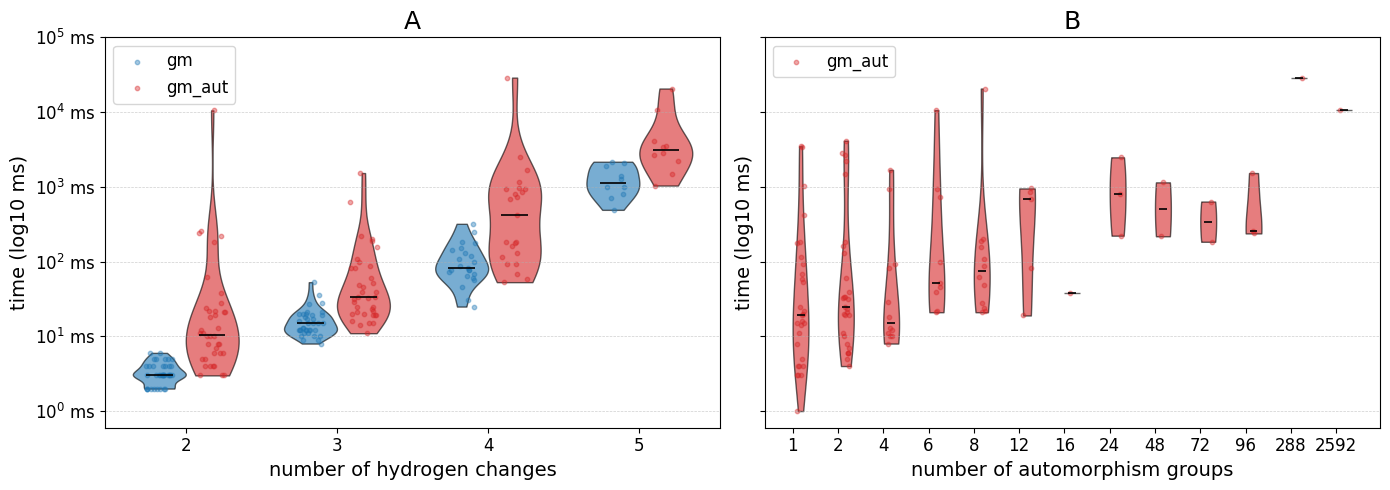

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_time_vs_ref_ms_log10(
    dfs, "rc_no_aut_no", "rc_no_aut_yes",
    ref="nH",
    ax=axes[0],
    label1="gm", label2="gm_aut",
    x_label='number of hydrogen changes',
    title = 'A',
)

plot_time_vs_ref_ms_log10(
   dfs, "rc_no_aut_no", "rc_no_aut_yes",
    ref="automorphisms",
    ax=axes[1],
    label1="gm", label2="gm_aut",
    x_label='number of automorphism groups',
    title = 'B',
)

fig.tight_layout()
# fig.savefig("hextend.pdf", dpi=300)
